# EDA of recipes data
## Contents:
- Data cleaning
- Exploration (servings, difficultry, calories, time, ingredients)

In [43]:
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import nltk
from wordcloud import WordCloud

# Cleaning

In [44]:
df = pd.read_csv('Cleaned_data.csv') # Read in data
del df['Unnamed: 0'] # Delete column 'Unnamed: 0'
df.head()

,Title,Ingredients,Servings,Difficulty,Calories,Time,URL,Ingredients_parsed,Ingredients_final
0,Asparagus stir-fry,"['350 g firm tofu', '2 teaspoons groundnut oil...",4,Not too tricky,248.0,00:00,https://www.jamieoliver.com/recipes/vegetable-...,firm tofu groundnut oil sesame seed cornflour ...,tofu cornflour wine garlic ginger beansprouts ...
1,Sweet potato fishcakes,"['500 g potatoes', '500 g sweet potatoes', '2 ...",4,Not too tricky,423.0,01:10,https://www.jamieoliver.com/recipes/fish-recip...,potato sweet potato red pepper extra virgin ol...,potato potato chipotle tabasco boned cucumber ...
2,Spring chicken stew,"['olive oil', '2 rashers of higher-welfare smo...",4,Not too tricky,549.0,01:10,https://www.jamieoliver.com/recipes/chicken-re...,olive oil rasher higher welfare smoked streaky...,bacon rosemary onion carrot potato pearl barle...
3,Chicken goujons,"['6 wholemeal pittas', '4 x 120 g free-range s...",4,Not too tricky,520.0,00:23,https://www.jamieoliver.com/recipes/chicken-re...,wholemeal pitta free range skinless chicken br...,pitta chicken basil egg garlic parmesan cheese...
4,Sweet & sour stir-fry,"['100 g fine rice noodles', '1 x 227 g tin of ...",2,Super easy,492.0,00:21,https://www.jamieoliver.com/recipes/vegetable-...,fine rice noodle tin pineapple chunk juice cor...,rice noodle pineapple chunk cornflour cashew o...


In [45]:
# 2 recipes have time in servings column
wrong = df['Servings']=='1 hour'
df.loc[wrong,'Time'] = '01:00' # Set time equal to 1 hour
df.loc[wrong,'Servings'] = np.NaN # Set servings to missing value

wrong2 = df['Servings']=='1 hour 10 minutes'
df.loc[wrong2,'Time'] = '01:10' # Set time equal to 1 hour 10 minutes
df.loc[wrong2,'Servings'] = np.NaN # Set servings to missing value

In [46]:
df.dtypes # See data types

Title                 object
Ingredients           object
Servings              object
Difficulty            object
Calories              object
Time                  object
URL                   object
Ingredients_parsed    object
Ingredients_final     object
dtype: object

In [47]:
df = df.replace('00:00', 'unknown') # Replace '00:00' with 'unknown'
df = df.replace('unknown', np.NaN) # Replace 'unknown' with missing values

In [48]:
df.isnull().sum()

Title                   0
Ingredients             0
Servings                2
Difficulty            125
Calories              125
Time                   10
URL                     0
Ingredients_parsed      0
Ingredients_final       0
dtype: int64

In [49]:
df['Calories'] = df['Calories'].astype(float) # Convert calories to floats

In [50]:
# Function that converts time to minutes, so it is easier for visualizations
def time_parser(time_str):

    # If it is empty then return missing value
    if pd.isna(time_str):
        return np.NaN

    else:
        hours_match = re.search(r"(\d{2}):", time_str) # Use RegEx to capture hours
        minutes_match = re.search(r":(\d{2})", time_str) # Use RegEx to capture minutes
        hours = int(hours_match.group(1)) if hours_match else 0
        minutes = int(minutes_match.group(1)) if minutes_match else 0

        total_minutes = hours * 60 + minutes # Get total minutes

        return total_minutes # Return minutes

In [51]:
# Apply on time column
df['Time'] = df['Time'].apply(time_parser)

In [52]:
df['Time'].head(5)

0     NaN
1    70.0
2    70.0
3    23.0
4    21.0
Name: Time, dtype: float64

In [53]:
df['Servings'].unique() # Get unique servings

array(['4', '2', '6', '16 tacos', '4 to 6',
       '4 +2 leftover meatball portions', '4 + 6 leftover fish fingers',
       '8', '6 as a side', '12 to 14', '6 or 12 as a starter',
       '6 to 8, with leftovers', '12', '1', '6-8', '4 - 6', '6 - 8', '10',
       '6 with leftovers', '4 rostis', '1 pizza', '4-6', '6 to 8',
       '8 to 10', '6, or 10 as a starter', '8 - 10', '10-12', '10–12',
       '4–6', '3', '8 to 10 as a starter',
       '3–4 (about 20  tortellini each)', '20 to 25', '2-4', '10 to 12',
       '2, or 4 as a side', '4 as a main, 6 as a starter', '4 as a main',
       '14', '4 adults or 6 children', 'enough to fill 30 tacos', '18',
       '8 as a side', '12 to 16', '3 litres',
       '12 plus lots of leftover ragù', '6 pizzas (2 large and 4 mini)',
       '30', '2-6', '6 (or 8 to 10 as a starter or side)',
       '4 (makes 8 fishcakes)', '16', '20', '8-10 with leftovers',
       '4 (makes 8 generous kebabs)', nan, 'enough for 1 pizza',
       '2 + 6 leftover daal portion

In [54]:
def servings_parse(servings):

    # Custom dictionary that converts some ambiguous servings to actual servings
    parse_dict = {'16 tacos': '8', '6 as a side': '3', '4 rostis': '2', '1 pizza': '2', 'enough to fill 30 tacos': '15', '8 as a side': '4', '6 pizzas (2 large and 4 mini)': '6', 'enough for 1 pizza': '2', '2 + 6 leftover daal portions': '6','30':'4'}

    # If it is empty then return missing value
    if pd.isna(servings):
        return np.NaN

    else:

        # Convert to servings if in dictionary above
        if servings in parse_dict:
            parsed = parse_dict[servings]

        else:
            parsed = re.sub(r'\(.*?\)', '',servings) # Get rid of brackets and any words in them
            parsed = re.sub(r'[-,+–].*', '', parsed) # Get rid of anything after a hyphen
            parsed = re.sub(r'to.*', '', parsed) # Get rid of anything after 'to'
            parsed = re.sub(r'or.*', '', parsed) # Get rid of anything after 'or'
            parsed = re.sub(r'[a-zA-Z\s]', '', parsed) # Get rid of any letters or spaces

        return parsed # Return parsed

In [55]:
# Apply servings_parse() on 'Servings' column
df['Servings_parsed'] = df['Servings'].apply(lambda x: servings_parse(x))
df[['Servings','Servings_parsed']].head(5)

,Servings,Servings_parsed
0,4,4
1,4,4
2,4,4
3,4,4
4,2,2


In [56]:
df['Servings_parsed'] = df['Servings_parsed'].astype(float) # Convert to float

In [57]:
df.Difficulty.unique() # Get unique values of 'Difficulty' column

array(['Not too tricky', 'Super easy', 'Showing off', nan], dtype=object)

In [58]:
# Define dictionary to convert difficulties to something more intuitive
diff_dict = {'Not too tricky': 'Medium', 'Super easy': 'Easy', 'Showing off': 'Hard'}
df.Difficulty = df.Difficulty.map(diff_dict) # Map using dicitonary
df.Difficulty.fillna('Unknown',inplace = True) # Fill missing values with 'Unknown'

In [59]:
df.head()

,Title,Ingredients,Servings,Difficulty,Calories,Time,URL,Ingredients_parsed,Ingredients_final,Servings_parsed
0,Asparagus stir-fry,"['350 g firm tofu', '2 teaspoons groundnut oil...",4,Medium,248.0,NaN,https://www.jamieoliver.com/recipes/vegetable-...,firm tofu groundnut oil sesame seed cornflour ...,tofu cornflour wine garlic ginger beansprouts ...,4.0
1,Sweet potato fishcakes,"['500 g potatoes', '500 g sweet potatoes', '2 ...",4,Medium,423.0,70.0,https://www.jamieoliver.com/recipes/fish-recip...,potato sweet potato red pepper extra virgin ol...,potato potato chipotle tabasco boned cucumber ...,4.0
2,Spring chicken stew,"['olive oil', '2 rashers of higher-welfare smo...",4,Medium,549.0,70.0,https://www.jamieoliver.com/recipes/chicken-re...,olive oil rasher higher welfare smoked streaky...,bacon rosemary onion carrot potato pearl barle...,4.0
3,Chicken goujons,"['6 wholemeal pittas', '4 x 120 g free-range s...",4,Medium,520.0,23.0,https://www.jamieoliver.com/recipes/chicken-re...,wholemeal pitta free range skinless chicken br...,pitta chicken basil egg garlic parmesan cheese...,4.0
4,Sweet & sour stir-fry,"['100 g fine rice noodles', '1 x 227 g tin of ...",2,Easy,492.0,21.0,https://www.jamieoliver.com/recipes/vegetable-...,fine rice noodle tin pineapple chunk juice cor...,rice noodle pineapple chunk cornflour cashew o...,2.0


In [60]:
# Make new df that doesn't contain the rows with missing values in servings
df_serve = df.dropna(subset='Servings_parsed')
df_serve['Servings_parsed'] = df_serve['Servings_parsed'].astype(int) # Convert 'servings_parsed' to int - for cleaner visualizations

C:\Users\Ming\AppData\Local\Temp\ipykernel_18016\1328766118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_serve['Servings_parsed'] = df_serve['Servings_parsed'].astype(int) # Convert 'servings_parsed' to int - for cleaner visualizations


# Exploration

In [61]:
sns.set_style('whitegrid') # Set sns style

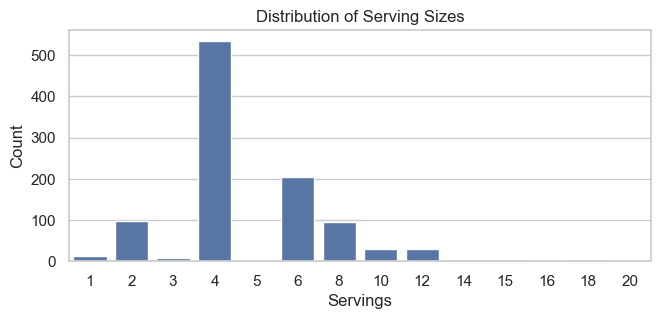

In [62]:
sns.set(rc={'figure.figsize':(7.5,3)})
sns.set_style('whitegrid')
sns.countplot(data=df_serve,x = 'Servings_parsed',color = '#4C72B0').set(title = 'Distribution of Serving Sizes',ylabel='Count', xlabel = 'Servings')

plt.show()

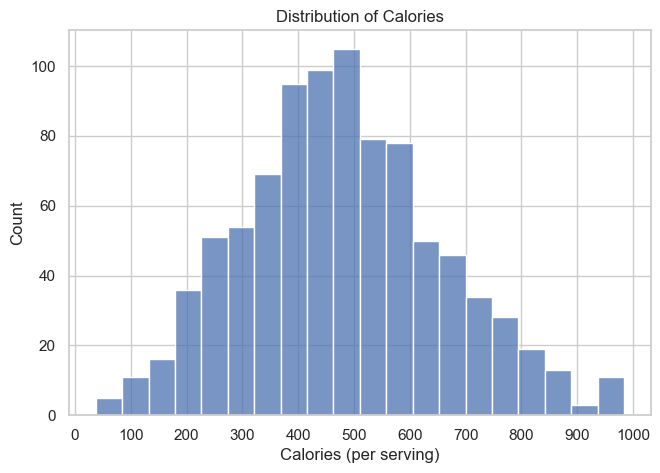

In [63]:
sns.set(rc={'figure.figsize':(7.5,5)})
sns.set_style('whitegrid')
ax = sns.histplot(data=df,x = 'Calories')
ax.set(title = 'Distribution of Calories', xlabel='Calories (per serving)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

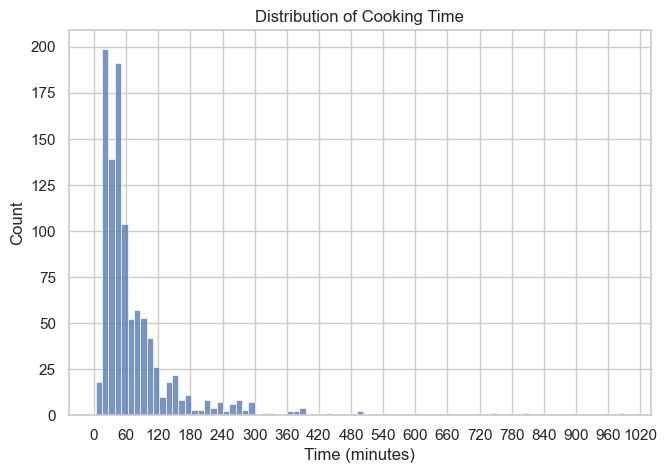

In [64]:
sns.set(rc={'figure.figsize':(7.5,5)})
sns.set_style('whitegrid')
ax = sns.histplot(data=df,x = 'Time')
ax.set(title = 'Distribution of Cooking Time', xlabel='Time (minutes)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.show()

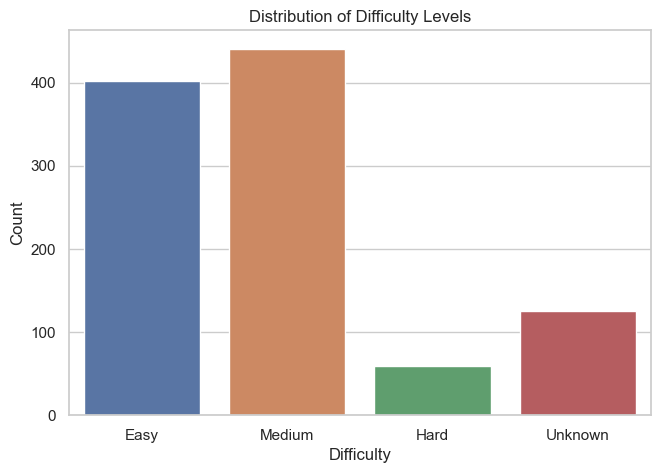

In [65]:
sns.countplot(x = 'Difficulty',data = df,order = ['Easy','Medium','Hard','Unknown']).set(title='Distribution of Difficulty Levels', ylabel='Count')
plt.show()

In [66]:
vocabulary = nltk.FreqDist()

for ingredients in df['Ingredients_final']:
    ingredients = ingredients.split()
    vocabulary.update(ingredients)
for word, frequency in vocabulary.most_common(200):
    print(f'{word};{frequency}')

garlic;642
onion;627
tomato;416
lemon;402
chicken;322
cheese;307
wine;294
coriander;242
egg;229
ginger;201
butter;185
potato;173
carrot;172
lime;163
thyme;163
rice;161
rosemary;144
yoghurt;135
mint;131
parmesan;128
pork;120
celery;117
basil;116
mustard;113
cumin;113
fennel;108
paprika;103
mushroom;103
milk;98
oyster;97
beef;80
pea;77
spinach;75
bacon;69
honey;69
cinnamon;65
oregano;64
shallot;61
lamb;58
lettuce;55
coconut;54
nutmeg;52
leek;50
cabbage;49
salmon;48
noodle;47
cheddar;47
sausage;47
sage;47
turmeric;46
broccoli;45
rocket;45
anchovy;44
breadcrumb;43
prawn;43
avocado;41
courgette;40
chickpea;37
shrimp;37
cucumber;36
feta;36
apple;36
pancetta;33
dill;33
ciabatta;33
watercress;33
chestnut;33
cayenne;30
pasta;30
ketchup;29
tofu;28
peanut;28
dressing;27
tortilla;27
wild;27
aubergine;27
masala;27
mozzarella;27
leg;27
pomegranate;27
chunk;26
spaghetti;26
almond;26
herb;26
turkey;26
ricotta;25
long;25
garam;25
shiitake;25
chorizo;25
can;25
gluten;25
belly;25
semi;24
lentil;24
shelle

The most common specific fresh ingredients are:
garlic: 642
onion: 627
tomato: 416
lemon:402
chicken: 322

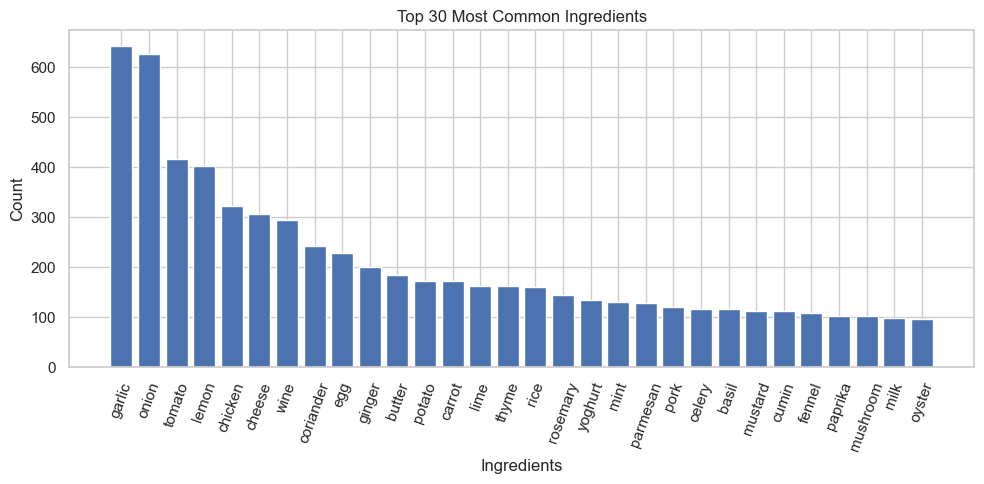

In [67]:
most_common = vocabulary.most_common(30)
words, frequencies = zip(*most_common)

# Create a bar plot
plt.figure(figsize=(10, 5))
plt.bar(words, frequencies)
plt.title("Top 30 Most Common Ingredients")
plt.xlabel("Ingredients")
plt.ylabel("Count")
plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

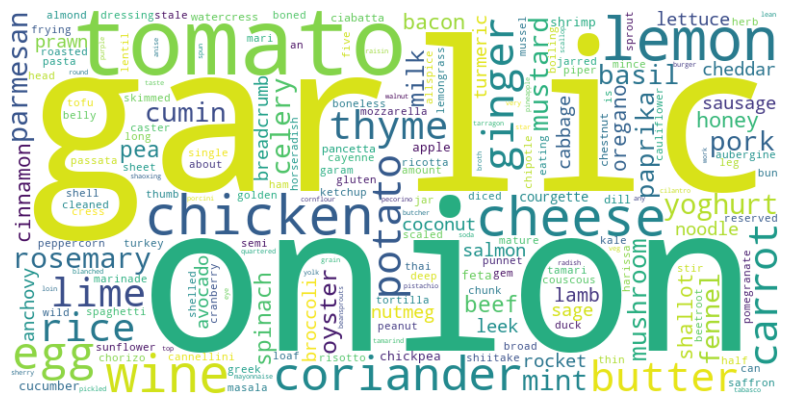

In [68]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(vocabulary)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

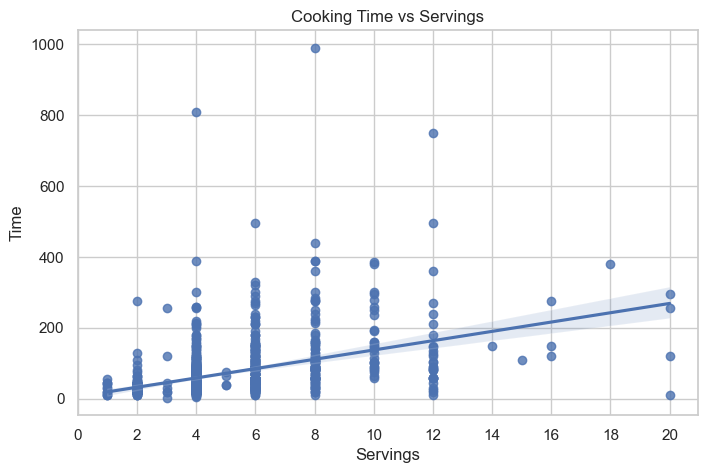

In [69]:
plt.figure(figsize=(8,5))
sns.regplot(data = df_serve, x = 'Servings_parsed', y = 'Time', fit_reg=True).set(title='Cooking Time vs Servings', xlabel='Servings')
plt.xticks(range(0, 22, 2))
plt.show()

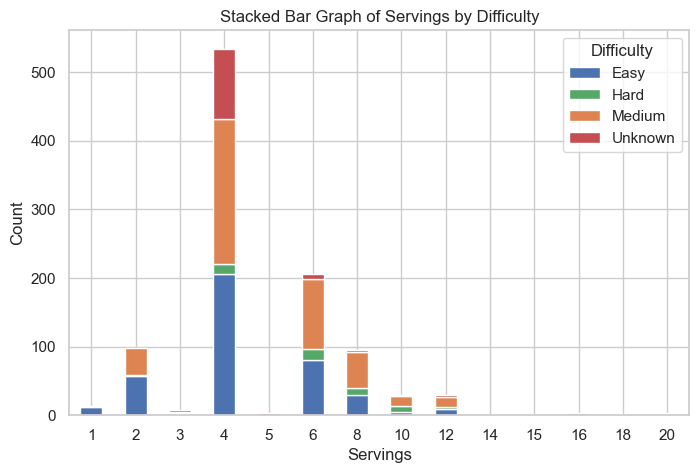

In [70]:
plt.rcParams["figure.figsize"] = (8,5)
counts_df = df_serve.groupby(['Servings_parsed', 'Difficulty']).size().unstack().fillna(0)
custom_colors = {'Easy': '#4C72B0', 'Medium': '#DD8452', 'Hard': '#55A868', 'Unknown': '#C44E52'}

# Create a stacked bar graph
counts_df.plot(kind='bar', stacked=True,color=[custom_colors[col] for col in counts_df.columns])

plt.title("Stacked Bar Graph of Servings by Difficulty")
plt.xlabel("Servings")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

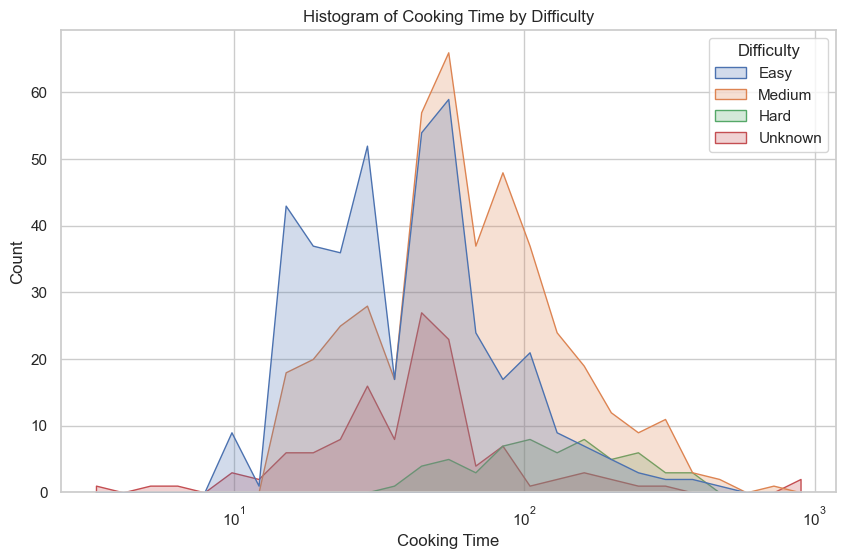

In [71]:
plt.figure(figsize=(10, 6))
custom_palette = {'Easy': '#4C72B0', 'Medium': '#DD8452', 'Hard': '#55A868', 'Unknown': '#C44E52'}
ax = sns.histplot(data=df, x='Time', hue = 'Difficulty',element='poly', log_scale=True,palette=custom_palette, hue_order=['Easy','Medium','Hard','Unknown'])
ax.set(title='Histogram of Cooking Time by Difficulty', xlabel='Cooking Time', ylabel='Count')

# Show the plot
plt.show()